In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay


import importlib
from glob import glob
import sys
import os
sys.path.append(os.path.abspath("../"))

# Importações dos seus modelos customizados
from src.BCE_Logistic_regression import LogisticRegression as BCE_Logistic
import src.Focal_Loss_Logistic_Regression
importlib.reload(src.Focal_Loss_Logistic_Regression)
from src.Focal_Loss_Logistic_Regression import LogisticRegression as Focal_Logistic
import src.Weighted_BCE_Logistic_regression
importlib.reload(src.Weighted_BCE_Logistic_regression)
from src.Weighted_BCE_Logistic_regression import LogisticRegression as Weighted_Logistic
from src.Weighted_BCE_Logistic_regression_New_Sigmoid import LogisticRegression as WeightedNewSigmoid_Logistic


In [2]:
# Caminho para os datasets
data_dir = "../data/class_imbalance/"
csv_files = glob(os.path.join(data_dir, "*.csv"))

In [3]:
# Inicializa armazenamento de métricas
model_names = ["BCE", "Focal", "Weighted", "Weighted_New_Sigmoid"]
metrics = {model: {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": []} for model in model_names}

# Cores para a ROC
colors = ["blue", "red", "green", "purple"]

In [4]:
# Observando que há label de target diferentes mas padronizado. 
for file in csv_files:
    try:
        df = pd.read_csv(file)
        target_col = df.columns[-1]
        unique_vals = df[target_col].dropna().unique()

        print(f"\n📄 Arquivo: {os.path.basename(file)}")
        print(f"🎯 Coluna alvo: {target_col}")
        print(f"🔍 Valores únicos: {unique_vals}")
    except Exception as e:
        print(f"⚠️ Erro ao processar {file}: {e}")


📄 Arquivo: dataset_312_scene.csv
🎯 Coluna alvo: Urban
🔍 Valores únicos: [0 1]

📄 Arquivo: dataset_947_arsenic-male-bladder.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['N' 'P']

📄 Arquivo: dataset_1022_mfeat-pixel.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: dataset_463_backache.csv
🎯 Coluna alvo: col_33
🔍 Valores únicos: [0 1]

📄 Arquivo: dataset_1039_hiva_agnostic.csv
🎯 Coluna alvo: label
🔍 Valores únicos: [-1  1]

📄 Arquivo: dataset_954_spectrometer.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['N' 'P']

📄 Arquivo: dataset_950_arsenic-female-lung.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['N' 'P']

📄 Arquivo: dataset_764_analcatdata_apnea3.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['N' 'P']

📄 Arquivo: dataset_962_mfeat-morphological.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: dataset_966_analcatdata_halloffame.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['N' 'P']

📄 Arquivo: dataset_38_sick.csv
🎯 Colu

In [5]:
# Função segura para padronizar a variável alvo:
def binarizar_target(y):
    """
    Normaliza uma variável alvo binária para conter apenas 0 e 1.
    Mantém a ordem original dos rótulos.
    """
    uniques = pd.Series(y).dropna().unique()

    if len(uniques) != 2:
        raise ValueError(f"Target não é binária: {uniques}")

    if set(uniques) == {0, 1}:
        return y  # já está ok
    elif set(uniques) == {True, False}:
        return pd.Series(y).astype(int)
    elif set(uniques) == {-1, 1}:
        return (pd.Series(y) == 1).astype(int)
    else:
        mapping = {val: i for i, val in enumerate(sorted(uniques))}
        return pd.Series(y).map(mapping)



📁 Processando: dataset_312_scene.csv
❌ Erro ao processar ../data/class_imbalance/dataset_312_scene.csv: cannot access local variable 'z_clipped' where it is not associated with a value

📁 Processando: dataset_947_arsenic-male-bladder.csv
❌ Erro ao processar ../data/class_imbalance/dataset_947_arsenic-male-bladder.csv: name 'LabelEncoder' is not defined

📁 Processando: dataset_1022_mfeat-pixel.csv
❌ Erro ao processar ../data/class_imbalance/dataset_1022_mfeat-pixel.csv: name 'LabelEncoder' is not defined

📁 Processando: dataset_463_backache.csv
❌ Erro ao processar ../data/class_imbalance/dataset_463_backache.csv: cannot access local variable 'z_clipped' where it is not associated with a value

📁 Processando: dataset_1039_hiva_agnostic.csv


KeyboardInterrupt: 

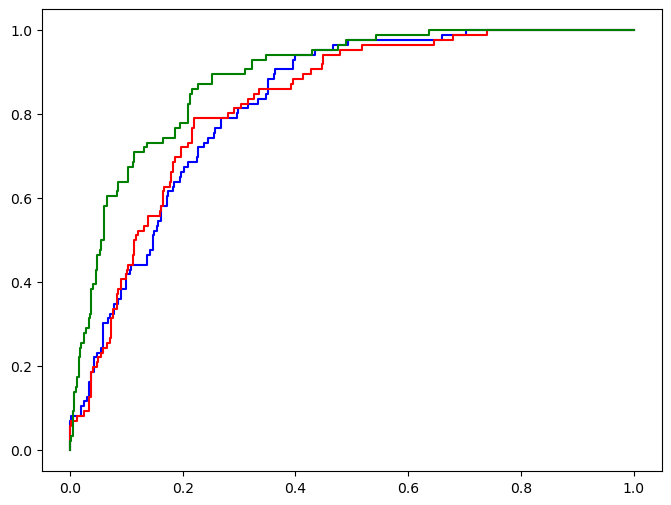

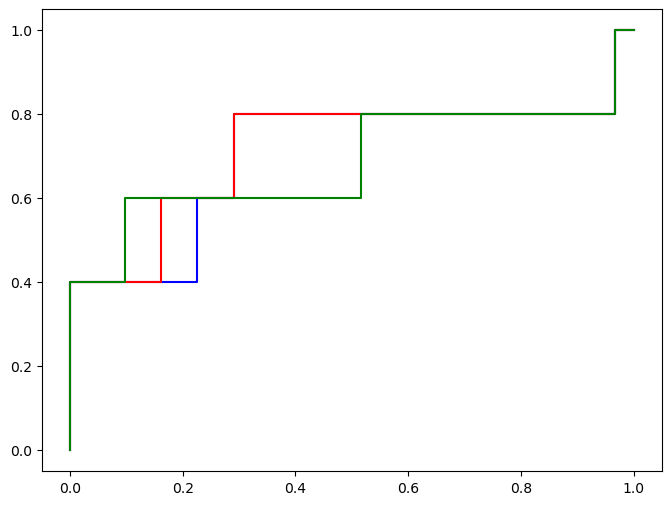

In [7]:
# Loop sobre arquivos
for file in csv_files:
    print(f"\n📁 Processando: {os.path.basename(file)}")
    try:
        df = pd.read_csv(file)

        # Substituições seguras
        for col in df.columns:
            if df[col].dtype == object:
                unique_vals = df[col].dropna().unique()
                for val in ["t", "f", "M", "F"]:
                    if val in unique_vals:
                        df[col] = df[col].replace({val: 1 if val in ["t", "M"] else 0})

        if "?" in df.values:
            df = df.replace("?", np.nan)

        df = df.dropna(axis=1, how='all')

        # Imputação
        num_cols = df.select_dtypes(include=['float64', 'int64']).columns
        cat_cols = df.select_dtypes(include=['object', 'bool']).columns
        for col in num_cols:
            df[col] = df[col].fillna(df[col].mean())
        for col in cat_cols:
            df[col] = df[col].astype(str).fillna("missing")
            df[col] = LabelEncoder().fit_transform(df[col])

        if df.isnull().values.any():
            print(f"⚠️ {os.path.basename(file)} ainda contém NaNs. Removendo linhas restantes...")
            df = df.dropna()

        # Separação
        if np.isnan(df.values).any():
            print(f"⚠️ {os.path.basename(file)} ainda contém NaNs após tudo. Ignorando.")
            continue
        X = df.iloc[:, :-1].values
        y_raw = df.iloc[:, -1]
        try:
            y = binarizar_target(y_raw).values
        except ValueError as e:
            print(f"⚠️ Dataset ignorado: {e}")
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # Modelos
        models = {
            "BCE": BCE_Logistic(lr=0.001, tolerance=1e-6, max_iters=1000),
            "Focal": Focal_Logistic(lr=0.001, tolerance=1e-6, max_iters=1000),
            "Weighted": Weighted_Logistic(lr=0.001, tolerance=1e-6, max_iters=1000),
            "Weighted_New_Sigmoid": WeightedNewSigmoid_Logistic(lr=0.001, tolerance=1e-6, max_iters=1000),
        }

        y_preds = {}
        plt.figure(figsize=(8, 6))

        for i, (name, model) in enumerate(models.items()):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)

            y_preds[name] = y_pred

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)

            metrics[name]["accuracy"].append(acc)
            metrics[name]["precision"].append(prec)
            metrics[name]["recall"].append(rec)
            metrics[name]["f1"].append(f1)
            metrics[name]["auc"].append(roc_auc)

            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})", color=colors[i])

        plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {os.path.basename(file)}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Matriz de confusão em grid único
        fig, axes = plt.subplots(1, 4, figsize=(20, 4))
        for i, name in enumerate(models):
            ConfusionMatrixDisplay.from_predictions(
                y_test, y_preds[name],
                display_labels=["Classe 0", "Classe 1"],
                cmap="Blues",
                values_format='d',
                ax=axes[i]
            )
            axes[i].set_title(name)

        plt.suptitle(f"Matrizes de Confusão - {os.path.basename(file)}", fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Erro ao processar {file}: {e}")


In [ ]:
# Exibir métricas agregadas
print("\n📊 MÉTRICAS MÉDIAS POR MODELO:")
for name in model_names:
    print(f"\n🔹 {name}")
    for metric in ["accuracy", "precision", "recall", "f1", "auc"]:
        values = metrics[name][metric]
        if values:
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric.capitalize():<10}: {mean:.4f} ± {std:.4f}")
        else:
            print(f"{metric.capitalize():<10}: N/A")


📊 MÉTRICAS MÉDIAS POR MODELO:

🔹 BCE
Accuracy  : 0.8352 ± 0.2455
Precision : 0.3261 ± 0.4373
Recall    : 0.3861 ± 0.4547
F1        : 0.3182 ± 0.4209
Auc       : 0.7123 ± 0.2401

🔹 Focal
Accuracy  : 0.8840 ± 0.1519
Precision : 0.3573 ± 0.4417
Recall    : 0.3622 ± 0.4353
F1        : 0.3374 ± 0.4140
Auc       : 0.7417 ± 0.2230

🔹 Weighted
Accuracy  : 0.7241 ± 0.3064
Precision : 0.3818 ± 0.3649
Recall    : 0.6829 ± 0.4261
F1        : 0.4300 ± 0.3567
Auc       : 0.7418 ± 0.2192

🔹 Weighted_New_Sigmoid
Accuracy  : 0.5922 ± 0.3601
Precision : 0.4026 ± 0.3725
Recall    : 0.8335 ± 0.3313
F1        : 0.4467 ± 0.3506
Auc       : 0.7825 ± 0.1856
